# Homework 2

In this assignment, you will be asked to implement both linear and nonlinear regression to fit the IR spectrum data with multiple Gaussians.

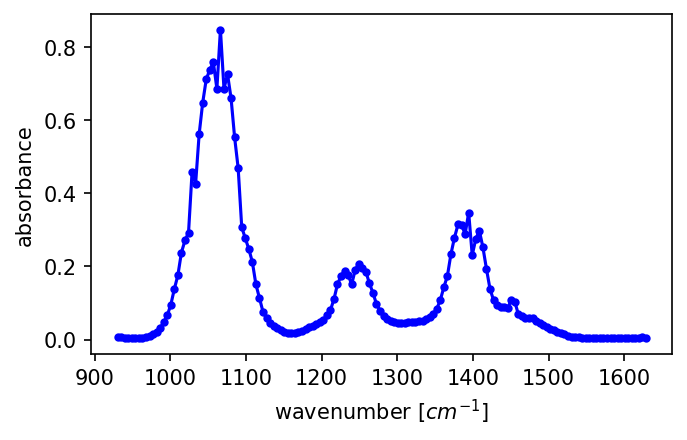

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('ethanol_IR.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['absorbance'].values

x_peak = x_all[100:250]
y_peak = y_all[100:250]

fig, ax = plt.subplots(figsize = (5, 3), dpi = 150)
ax.plot(x_peak, y_peak, '-b', marker = '.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

## 1. Gaussian Features

You will create a set of evenly-spaced Gaussians which will be used as features in the next step. First, write a function `gaussian_features` that generates `N` evenly-spaced Gaussians with a fixed width `sigma` in a given range of `x`. The return value `features` should be an array (or matrix) with dimensions of (length of `x` X `N`).

In [2]:
def gaussian_features(x, N, sigma):
########################################
# Start your code here
    features = np.zeros((len(x), N))
    xk = np.linspace(x.min(), x.max(), N)
    for i in range(N):
        features[:, i] = np.exp( -(x - xk[i])**2 / 2 / sigma**2)
########################################
    return features

Use `gaussian_features` to plot 8 evenly-spaced Gaussians from 900 to 1700 with resolution of 150 (e.g. `len(x)=150`) and a width of 100 (e.g. `sigma=100`).

In [3]:
import numpy as np

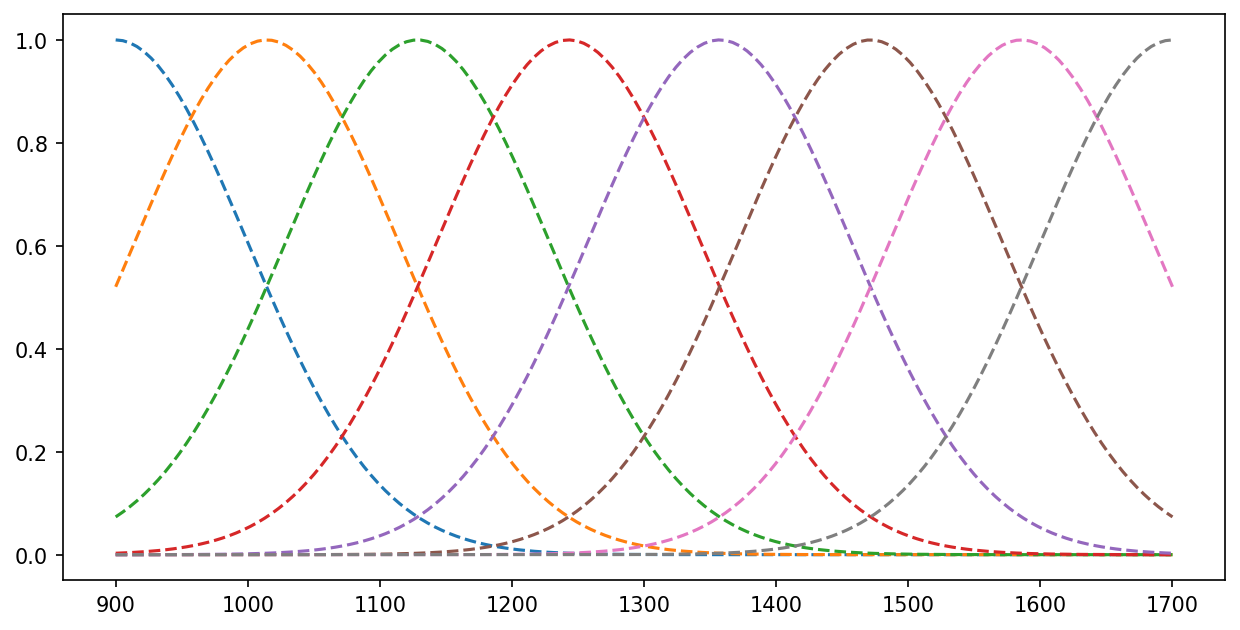

In [4]:
x = np.linspace(900, 1700, 150)
features = gaussian_features(x, 8, 100)

fig, ax = plt.subplots(figsize = (10, 5), dpi = 150)
for i in range(features.shape[1]):
    ax.plot(x, features[:, i], '--')

You want to fit `y_peak` with these newly created Gaussian features. Using general linear regression with the new features, plot the result of regression along with the original `y_peak`. You may add an intercept column to determine whether adding an intercept results in a better fitting.

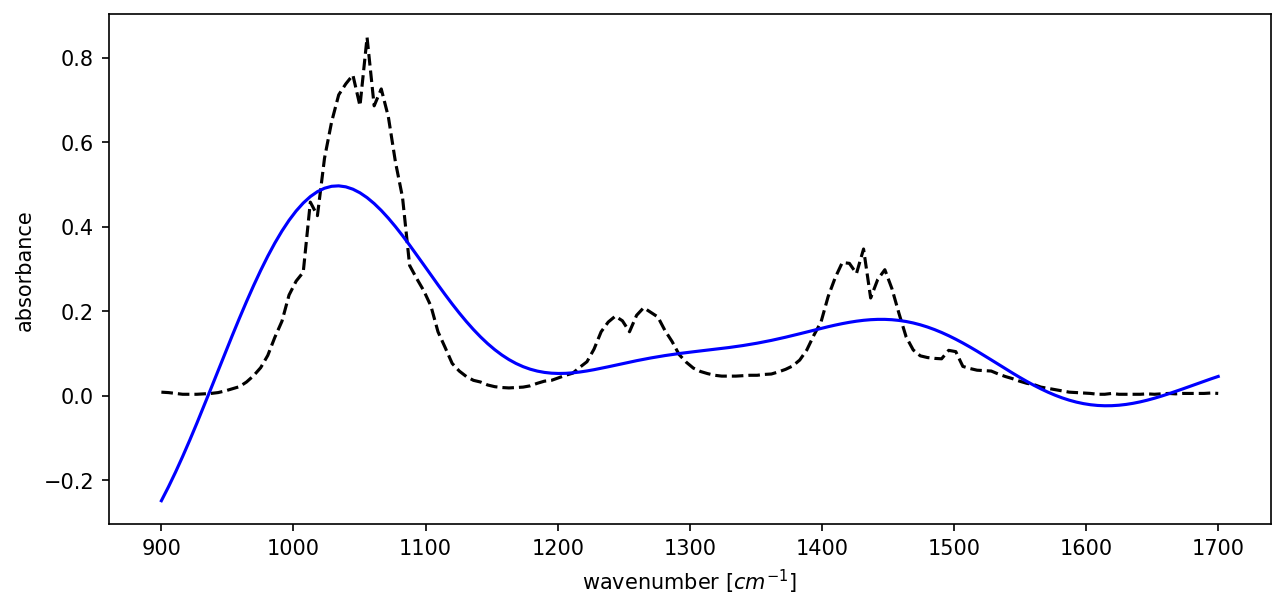

In [5]:
# no intercept

x = np.linspace(900, 1700, 150)
features = gaussian_features(x, 8, 100)

A = features.T@features
b = features.T@y_peak

w = np.linalg.solve(A, b)

fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)
ax.plot(x, y_peak, '--k')
ax.plot(x, features@w, '-b')

ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

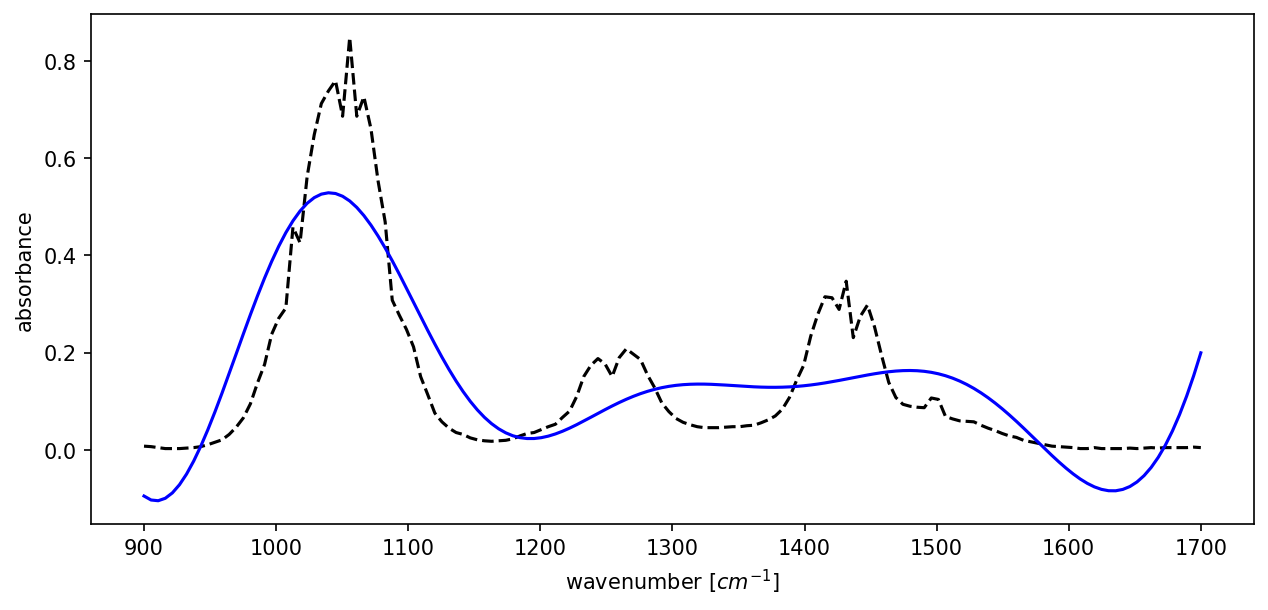

In [6]:
# with intercept

x = np.linspace(900, 1700, 150)
features = gaussian_features(x, 8, 100)

## intercept column
intercept = np.ones((features.shape[0], 1))

## pad the intercept column to the features matrix
features_w_int = np.append(intercept, features, axis = 1)

A = features_w_int.T@features_w_int
b = features_w_int.T@y_peak

## w.shape will be (9,) which was originally (8,)
w = np.linalg.solve(A, b)

fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)
ax.plot(x, y_peak, '--k')
ax.plot(x, features_w_int@w, '-b')

ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

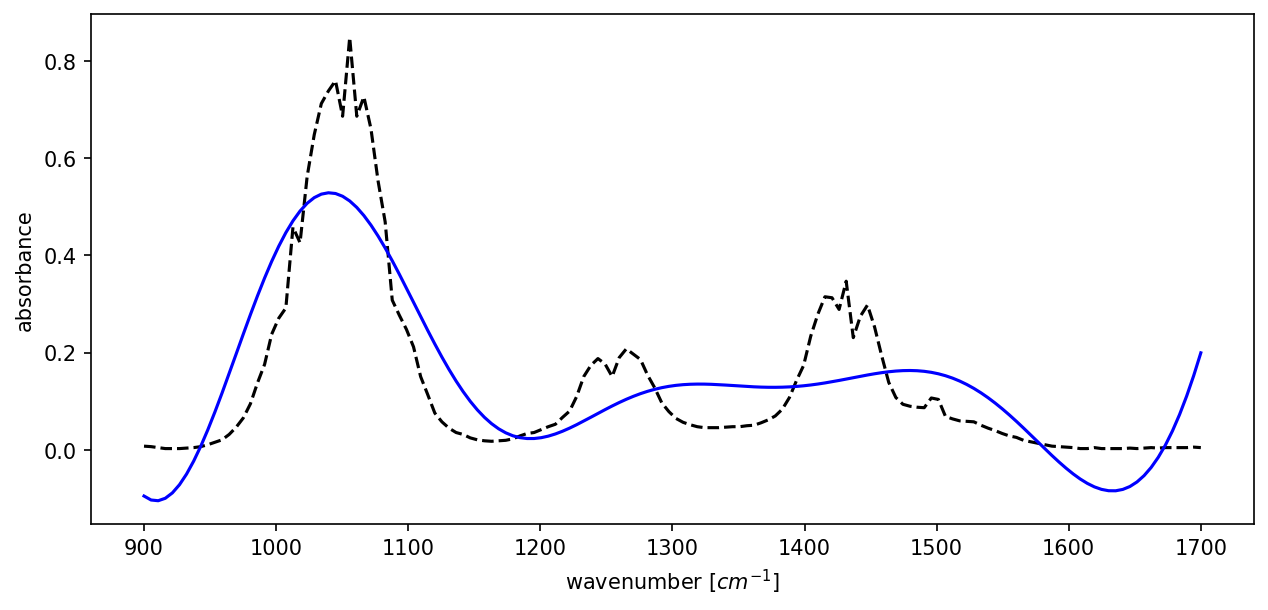

In [7]:
# using LinearRegression from scikit-learn with fit_intercept = True
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(features, y_peak)
y_hat = lr.predict(features)

fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)
ax.plot(x, y_peak, '--k')
ax.plot(x, y_hat, '-b')

ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

Increase the number of Gaussians to 30. Repeat the linear regression and plot the results again.

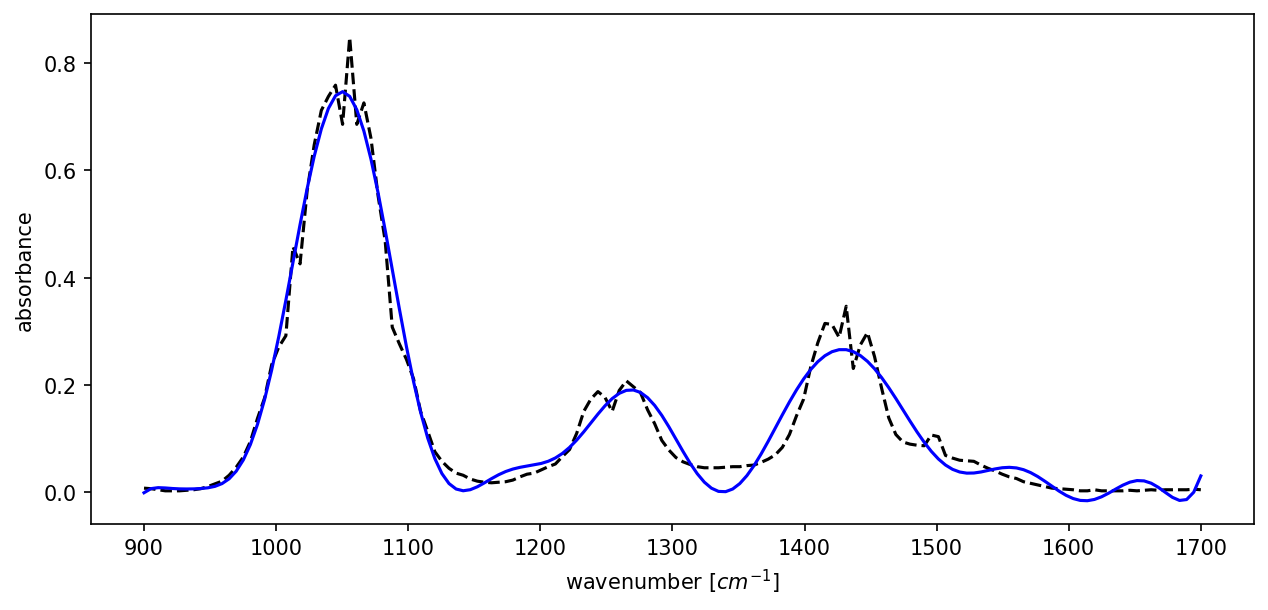

In [8]:
x = np.linspace(900, 1700, 150)
features = gaussian_features(x, 30, 100)

## intercept column
intercept = np.ones((features.shape[0], 1))

## pad the intercept column to the features matrix
features_w_int = np.append(intercept, features, axis = 1)

A = features_w_int.T@features_w_int
b = features_w_int.T@y_peak

## w.shape will be (9,) which was originally (8,)
w = np.linalg.solve(A, b)

fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)
ax.plot(x, y_peak, '--k')
ax.plot(x, features_w_int@w, '-b')

ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

In which case do you think the fitting worked better? How would the number of Gaussians affect the fitting quality? Briefly describe your answer.

## 2. Nonlinear Regression

In the previous problem, we set widths of multiple Gaussians to be the same. Next, we will remove this constraint by implementing nonlinear regression. Fortunately, we have already covered how to find the optimal widths and positions of Gaussians in the Skill Check. Use the `grad_descent` function you've made in the Skill Check and fit `y_peak` with 3 Gaussians. Plot the results along with `y_peak`. You should be able to set the initial guesses yourself using a combination of intuition, results from generalized linear regression, and trial and error.

In [9]:
import autograd.numpy as np
from autograd import grad

In [10]:
def loss(lamda, X, y, N):
    y_i = np.zeros(len(y))
    for i in range(N):
        y_i += lamda[i] * np.exp(-(X-lamda[i+N])**2 / 2 / lamda[i+2*N]**2)
    return ((y - y_i)**2).mean()

def g(lamda, X = x_peak, y = y_peak, N = 3):
    return loss(lamda, X, y, N)

diff_g = grad(g)

def grad_descent(lamda, diff_g, h, tol):
    err = np.inf
    current_lamda = lamda
    while err > tol:
        new_lamda = current_lamda - h * np.array(diff_g(current_lamda))
        err = np.linalg.norm(current_lamda - new_lamda)
        current_lamda = new_lamda
        
    return new_lamda

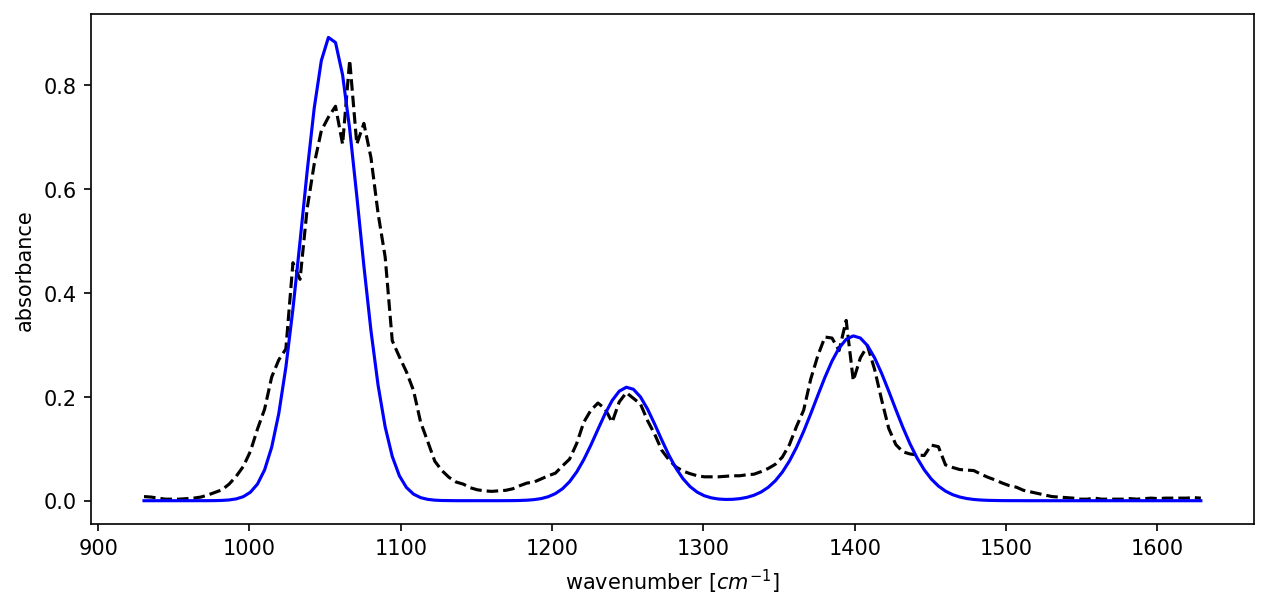

In [11]:
init_lamda = init_lamda = np.array([0.6, 0.7, 0.3, 1050., 1250., 1400., 10., 20., 25.])
opt_lamda = grad_descent(init_lamda, diff_g, 0.1, 0.0001)

y_hat = np.zeros(len(y_peak))
for i in range(3):
    y_hat += opt_lamda[i] * np.exp(-(x_peak-opt_lamda[i+3])**2 / 2 / opt_lamda[i+2*3]**2)
    
fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)
ax.plot(x_peak, y_peak, '--k')
ax.plot(x_peak, y_hat, '-b')

ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

Repeat the gradient descent method with 7 Gaussians. Print the weights.

In [12]:
def loss(lamda, X, y, N):
    y_i = np.zeros(len(y))
    for i in range(N):
        y_i += lamda[i] * np.exp(-(X-lamda[i+N])**2 / 2 / lamda[i+2*N]**2)
    return ((y - y_i)**2).mean()

def g(lamda, X = x_peak, y = y_peak, N = 7):
    return loss(lamda, X, y, N)

diff_g = grad(g)

def grad_descent(lamda, diff_g, h, tol):
    err = np.inf
    current_lamda = lamda
    while err > tol:
        new_lamda = current_lamda - h * np.array(diff_g(current_lamda))
        err = np.linalg.norm(current_lamda - new_lamda)
        current_lamda = new_lamda
        
    return new_lamda

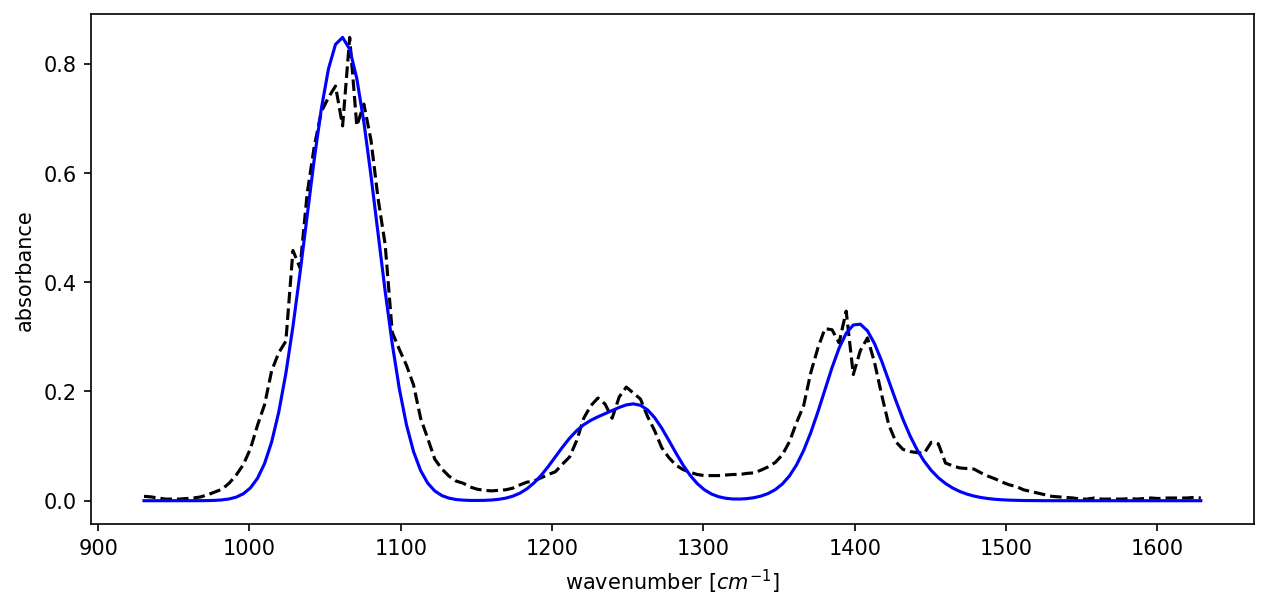

In [13]:
init_lamda = init_lamda = np.array([0.6, 0.7, 0.3, 0.3, 0.3, 0.3, 0.3, 1050., 1060., 1070., 1220., 1260., 1400., 1410., 20., 20., 20., 20., 20., 20., 30.])
opt_lamda = grad_descent(init_lamda, diff_g, 0.1, 0.0001)

y_hat = np.zeros(len(y_peak))
for i in range(7):
    y_hat += opt_lamda[i] * np.exp(-(x_peak-opt_lamda[i+7])**2 / 2 / opt_lamda[i+2*7]**2)
    
fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)
ax.plot(x_peak, y_peak, '--k')
ax.plot(x_peak, y_hat, '-b')

ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

As the number of Gaussians taking place in nonlinear regression increases, it is more likely to have some negative weights as a result. However, we want our results to be an interpolation of positive peaks only, making the regression more physically relevant. Therefore, let's add a constraint that all weights should be positive. Modify the loss function to meet the new constraint. You can provide the answer by editing the loss function in a code block or by proposing a new analytic loss function. You do not need to apply the new loss function, but doing so may help you check your answer.

In [14]:
def loss_mod(lamda, X, y, N):
    y_i = np.zeros(len(y))
    for i in range(N):
        y_i += lamda[i] * np.exp(-(X-lamda[i+N])**2 / 2 / lamda[i+2*N]**2)
        
    # penalize the negative weights (soft constraint)
    MSE = ((y-y_i)**2).mean()
    weights = lamda[:N]
    return MSE + np.linalg.norm(abs(weight) - weight)

In [15]:
def loss_mod(lamda, X, y, N):
    y_i = np.zeros(len(y))
    # force weights to be positive (hard constraint)
    for i in range(N):
        y_i += abs(lamda[i]) * np.exp(-(X-lamda[i+N])**2 / 2 / lamda[i+2*N]**2)
    
    return ((y-y_i)**2).mean()